# Training on initial DFT data
See how well we do with only the first 1.7k training entries.

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from fff.learning.gc.functions import GCSchNetForcefield
from ase.db import connect
from random import shuffle
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
start_name = 'dft_md-25000_ttm-100k'
basis = 'aug-cc-pvdz'
short_basis = f'a{basis[-3:]}'
reset_weights = True

## Load Training Data
Load in the initial training set and filtering to use only a single DFT method

In [3]:
init_db = Path(f'initial-database-{short_basis}.db')
if not init_db.exists():
    with connect('../../1_initial-database/initial.db') as db:
        all_strcs = [a.toatoms() for a in db.select(basis=basis)]
    shuffle(all_strcs)

    with connect(init_db, append=False) as db:
        for atoms in all_strcs:
            db.write(atoms)
else:
    with connect(init_db) as db:
        all_strcs = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(all_strcs)} structures')

Loaded 1720 structures


Save the first 10% as validation

In [4]:
cut = len(all_strcs) // 10

Save it to a database that contains only the structures we used for training

## Load the Model
Get the model with the updated means

In [5]:
model_dir = Path('best-models/') / start_name
model = torch.load(model_dir / f'{short_basis}-starting-model', map_location='cuda')

If desired, reset the weights

In [6]:
if reset_weights:
    atomrefs = model.atom_ref.weight.cpu().detach()
    model.reset_parameters()
    with torch.no_grad():
        model.atom_ref.weight[:] = atomrefs

## Get the pre-training performance
See how well we do without any modifications

In [7]:
interface = GCSchNetForcefield()

In [8]:
%%time
energy, forces = interface.evaluate(model, all_strcs, device='cuda')

CPU times: user 2.54 s, sys: 254 ms, total: 2.79 s
Wall time: 2.81 s


Plot the performance

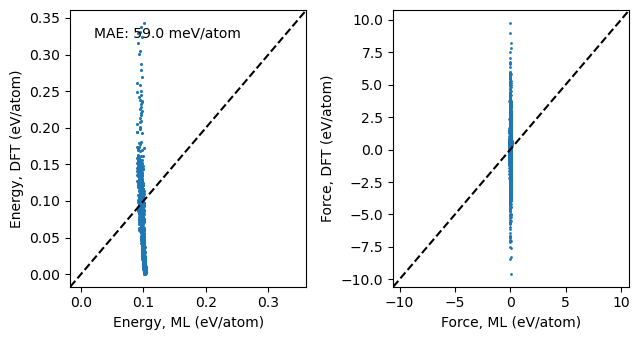

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5))

# Plot the energies
ax = axs[0]
n_atoms = [len(a) for a in all_strcs]
dft_energies = np.array([a.get_potential_energy() / len(a) for a in all_strcs])
ax.scatter(np.divide(energy, n_atoms) - dft_energies.min(), dft_energies - dft_energies.min(), s=1.5)
mae = np.abs(np.divide(energy, n_atoms) - dft_energies).mean()
ax.text(0.1, 0.9, f'MAE: {mae*1000:.1f} meV/atom', transform=ax.transAxes)

ax.set_xlabel('Energy, ML (eV/atom)')
ax.set_ylabel('Energy, DFT (eV/atom)')

# Plot the forces
ax = axs[1]
dft_forces = np.vstack([a.get_forces() for a in all_strcs]).flatten()
ml_forces = np.vstack(forces).flatten()
ax.scatter(ml_forces, dft_forces, s=1)

ax.set_xlabel('Force, ML (eV/atom)')
ax.set_ylabel('Force, DFT (eV/atom)')

for ax in axs:
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())

    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.tight_layout()

## Run the Training
Just do a few op

In [10]:
%%time
model, log = interface.train(model, all_strcs[cut:], all_strcs[:cut], num_epochs=512, learning_rate=1e-3, device='cuda')

CPU times: user 8min 18s, sys: 390 ms, total: 8min 19s
Wall time: 8min 19s


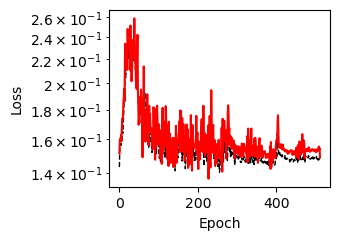

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(log['epoch'], log['train_loss_total'], '--', color='k', lw=1, label='Train')
ax.plot(log['epoch'], log['valid_loss_total'], '-', color='r', label='Validation')

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

## Repeat analysis after training
See how good we are

In [12]:
%%time
energy, forces = interface.evaluate(model, all_strcs, device='cuda')

CPU times: user 2.27 s, sys: 80 ms, total: 2.35 s
Wall time: 2.36 s


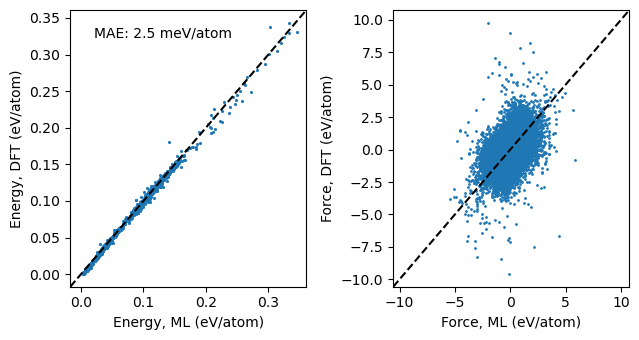

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5))

# Plot the energies
ax = axs[0]
n_atoms = [len(a) for a in all_strcs]
dft_energies = np.array([a.get_potential_energy() / len(a) for a in all_strcs])
ax.scatter(np.divide(energy, n_atoms) - dft_energies.min(), dft_energies - dft_energies.min(), s=1.5)
mae = np.abs(np.divide(energy, n_atoms) - dft_energies).mean()
ax.text(0.1, 0.9, f'MAE: {mae*1000:.1f} meV/atom', transform=ax.transAxes)

ax.set_xlabel('Energy, ML (eV/atom)')
ax.set_ylabel('Energy, DFT (eV/atom)')

# Plot the forces
ax = axs[1]
dft_forces = np.vstack([a.get_forces() for a in all_strcs])
ml_forces = np.vstack(forces)
rmsd_force = np.sqrt(np.power(np.linalg.norm(dft_forces - ml_forces, axis=1), 2).mean())
ax.scatter(ml_forces.flatten(), dft_forces, s=1)


ax.set_xlabel('Force, ML (eV/atom)')
ax.set_ylabel('Force, DFT (eV/atom)')

for ax in axs:
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())

    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

fig.tight_layout()

We correct some of the remaining differences. Success!

## Save the results
For use later

In [14]:
if reset_weights:
    result_dir = Path('best-models/no-pretraining') / f'{short_basis}-tuned'
else:
    result_dir = model_dir / f'{short_basis}-tuned'
if result_dir.is_dir():
    shutil.rmtree(result_dir)
result_dir.mkdir(parents=True)

In [15]:
torch.save(model, result_dir / 'model')

In [16]:
log.to_csv(result_dir / 'log.csv', index=False)